In [ ]:
#!cd '/content/drive/MyDrive/Sem 2/CSE 676 - DL/Project/Final'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Text to Image 🧙🏻‍♂️ ✨**

In [ ]:
#Abhishek
path='/content/drive/MyDrive/abhi_DL_GAN/Project/'
#Saj
#path='/content/drive/MyDrive/Sem 2/CSE 676 - DL/Project/'

In [ ]:
import tensorflow as tf

import pickle
import gensim

import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import expand_dims, linspace

import numpy as np


from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from random import randint, choice

import time
from keras.layers.advanced_activations import PReLU
from tensorflow.keras.utils import plot_model
from IPython.display import clear_output

import matplotlib.pyplot as pyplot
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Importing Pickle and Word2Vec model 🗃️**

In [ ]:
#for Birds
# data = pickle.load(open(path + "Final/Bird/Pickles/image_vectors.p", "rb"))
# word_vector = pickle.load(open(path + "Final/Bird/Pickles/word_vector_min_bird.p", "rb"))
# model = gensim.models.KeyedVectors.load_word2vec_format(path + 'Final/word2vec_pretrained_model/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#For flickr8K
data = pickle.load(open(path + "Final/Pickles/image_vectors.p", "rb"))
word_vector = pickle.load(open(path + "Final/Pickles/flickr8k_embeddings.p", "rb"))
model = gensim.models.KeyedVectors.load_word2vec_format(path + 'Final/word2vec_pretrained_model/GoogleNews-vectors-negative300.bin', binary=True)

## **Setting lables, Caption for corresponding images | Adding jitter (zoom) 🔊**

8127
8127
391723162_3bdeb7ea33.jpg
391723162_3bdeb7ea33.jpg
375171241_0302ad8481.jpg
380034515_4fbdfa6b26.jpg
3717531382_e1e05e22c5.jpg
381976882_0063d16d88.jpg
380537190_11d6c0a412.jpg
379006645_b9a2886b51.jpg
397451339_76a84bd310.jpg


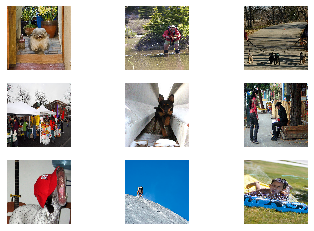

In [ ]:
def zoom(image):
  image = expand_dims(image, 0) #add additional dimension necessary for zooming
  image = image_augmentation_generator.flow(image, batch_size=1)
  result = image[0].reshape(image[0].shape[1:]) #remove additional dimension (1, 64, 64, 3) to (64, 64, 3)
  return result

image_augmentation_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.8, 1.0]) # random zoom proves to be helpful in capturing more details https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

n = 227
image_embeddings = []
captions = []
labels = []
for i, k in enumerate(data.keys()):
  if k not in  word_vector:
    continue
  image_embeddings.append(data[k])
  captions.append(word_vector[k])
  labels.append(k)
  if i % n == 0:
   image_embeddings.append(zoom(data[k]))
   captions.append(word_vector[k])
   labels.append(k)

print(len(captions))
print(len(image_embeddings))

pyplot.axis('off')
slcie = image_embeddings[3:33]
for i in range(9):
  pyplot.subplot(3, 3, i+1)
  pyplot.imshow(array_to_img(slcie[i]))
  print(labels[i])
  pyplot.axis('off')

pyplot.show()

RUN THE BELOW CODES FOR FLICKR ONLY

In [ ]:
#for flickr8k only
# Replacing NaN and appending 1 to match dimension=
a=np.argwhere(np.isnan(captions))
for i in a:
  captions[i[0]][i[1]]=0

image_embeddings.append(image_embeddings[8126])
captions.append(captions[8126])
labels.append(labels[8126])

In [ ]:
print(len(image_embeddings),
len(captions),
len(labels))

8128 8128 8128


## **Vectorizing**

In [ ]:
def get_random_word_vectors_from_dataset(n_samples):
  ix = np.random.randint(0, len(captions), n_samples)
  return np.asarray(captions)[ix]

In [ ]:
def generate_random_vectors(n_samples):  
  vectorized_random_captions = []

  for n in range(n_samples):
    rnd = randint(8, 25)
    result_array = np.empty((0, 300))
    for i in range(rnd):
      result_array = np.append(result_array, [model[choice(model.index2entity)]], axis=0)
    vectorized_random_captions.append(np.mean(result_array, axis=0).astype('float32'))

  return np.array(vectorized_random_captions)

## **Discriminator Model ⚙️**


In [ ]:
# Discriminator model
def define_discriminator():
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    #batch_init = tf.random_normal_initializer(1., 0.02)
    word_vector_dim = 300
    dropout_prob = 0.25

    in_label = layers.Input(shape=(300,))
  
    n_nodes = 3 * 64 * 64
    li = layers.Dense(n_nodes)(in_label)
    li = layers.Reshape((64, 64, 3))(li)
    dis_input = layers.Input(shape=(64, 64, 3))

    merge = layers.Concatenate()([dis_input, li])
    #check output
    discriminator = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same")(merge)
    discriminator = layers.LeakyReLU(0.2)(discriminator)
    discriminator = layers.GaussianNoise(0.2)(discriminator)
    
    #regularization layer to avoid overfitting
    discriminator = layers.Conv2D(filters=96, kernel_size=(3, 3), strides=(2, 2), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU()(discriminator)

    discriminator = layers.Conv2D(filters=192, kernel_size=(3, 3), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(2, 2), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=192, kernel_size=(3, 3), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(2, 2), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Conv2D(filters=768, kernel_size=(3, 3), padding="same",kernel_initializer=kernel_init)(discriminator)
    discriminator = layers.BatchNormalization(momentum=0.8)(discriminator)
    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Flatten()(discriminator)

    discriminator = layers.Dense(1024)(discriminator)

    discriminator = layers.LeakyReLU(0.2)(discriminator)

    discriminator = layers.Dense(1)(discriminator)

    discriminator_model = Model(inputs=[dis_input, in_label], outputs=discriminator)

    discriminator_model.summary()

    return discriminator_model

## **Generator Model 🚀**

In [ ]:
# Using ResNet to improve image feature laerning
def resnet_block(model, kernel_size, filters, strides):
    gen = model #identity
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.8)(model)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)
    model = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.8)(model)
    model = layers.Add()([gen, model])
    return model

In [ ]:
# Generator model
def define_generator():
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    #batch_init = tf.random_normal_initializer(1., 0.02)

    random_input = layers.Input(shape=(100,))
    text_input1 = layers.Input(shape=(300,))
    text_layer1 = layers.Dense(8192)(text_input1)
    text_layer1 = layers.Reshape((8, 8, 128))(text_layer1)

    n_nodes = 128 * 8 * 8
    gen_input_dense = layers.Dense(n_nodes)(random_input)
    generator = layers.Reshape((8, 8, 128))(gen_input_dense)

    merge = layers.Concatenate()([generator, text_layer1])

    model = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding="same")(merge)
    model = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(model)

    gen_model = model

    for _ in range(4):
      model = resnet_block(model, 3, 64, 1)

    model = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(model)
    model = layers.BatchNormalization(momentum=0.8)(model)
    model = layers.Add()([gen_model, model])
    #check summary here
    
    # model = layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    # model = layers.LeakyReLU(0.2)(model)
    model = layers.Conv2DTranspose(filters=768, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=384, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=192, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer=kernel_init)(model)
    model = layers.LeakyReLU(0.2)(model)

    model = layers.Conv2D(3, (3, 3), padding='same', activation='tanh')(model)

    generator_model = Model(inputs=[random_input, text_input1], outputs=model)

    generator_model.summary()

    return generator_model


Generating Latent Noise

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions = get_random_word_vectors_from_dataset(n_samples)
    return [x_input, text_captions]

In [ ]:
def noisy_labels(y, p_flip):
    n_select = int(p_flip * int(y.shape[0]))
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)

    op_list = []
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1.0, y[i]))
        else:
            op_list.append(y[i])

    outputs = tf.stack(op_list)
    return outputs

In [ ]:
def load_data():
    return asarray(image_embeddings), asarray(captions).astype('float32')

#label smoothing
def smooth_positive_labels(y):
	return y - 0.3 + (np.random.random(y.shape) * 0.5)
 
def smooth_negative_labels(y):
	return y + np.random.random(y.shape) * 0.3

## **Generating and Saving images 🎉**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[7, 7])

  for i in range(predictions.shape[0]):
      pyplot.subplot(5, 5, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  #Birds
  #pyplot.savefig('/content/drive/MyDrive/abhi_DL_GAN/Project/Final/Bird/bird_gen_images/bird_image_at_epoch_{:04d}.png'.format(epoch))
  
  #Flick8k
  pyplot.savefig('/content/drive/MyDrive/abhi_DL_GAN/Project/Final/flickr_gen_images/Flickr8k_images_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()

## **Discriminator Loss 📈**

In [ ]:
def discriminator_loss(r_real_output_real_text, f_fake_output_real_text_1, f_real_output_fake_text):
   alpha = 0.5
   real_output_noise = smooth_positive_labels(noisy_labels(tf.ones_like(r_real_output_real_text), 0.10))
   fake_output_real_text_noise_1 = smooth_negative_labels(tf.zeros_like(f_fake_output_real_text_1))
   real_output_fake_text_noise = smooth_negative_labels(tf.zeros_like(f_real_output_fake_text))

   real_loss = tf.reduce_mean(binary_cross_entropy(real_output_noise, r_real_output_real_text))
   fake_loss_ms_1 = tf.reduce_mean(binary_cross_entropy(fake_output_real_text_noise_1, f_fake_output_real_text_1))
   fake_loss_2 = tf.reduce_mean(binary_cross_entropy(real_output_fake_text_noise, f_real_output_fake_text))

   total_loss = real_loss + alpha * fake_loss_2 + (1-alpha) * fake_loss_ms_1 
   return total_loss

## **Generator Loss📉**

In [ ]:
def generator_loss(f_fake_output_real_text):
   return tf.reduce_mean(binary_cross_entropy(tf.ones_like(f_fake_output_real_text), f_fake_output_real_text))

## Plot Loss

In [ ]:
def plot_history(d1_hist, g_hist):
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='disc')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	pyplot.show()
	pyplot.savefig('/content/drive/MyDrive/abhi_DL_GAN/Project/Final/flickr_gen_images') #flickr
	#pyplot.savefig('/content/drive/MyDrive/abhi_DL_GAN/Project/Final/Bird/bird_gen_images') #birds


## **Training train 👷🏼**

Time for epoch 540 is 27.34685182571411 sec


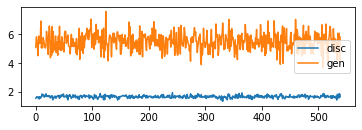

<Figure size 432x288 with 0 Axes>

In [25]:
@tf.function
def train_step(images, epoch):

  #define half_batch
  latent_dim = 100
  n_batch = 64

  noise_1 = tf.random.normal([32, latent_dim])
  noise_2 = tf.random.normal([32, latent_dim])
  real_captions = images[1]
  print(real_captions)
  real_images = images[0]
  print(real_images)

  random_captions = generate_random_vectors(n_batch)
  random_captions_1, random_captions_2  = tf.split(random_captions, 2, 0)
  real_captions_1, real_captions_2  = tf.split(real_captions, 2 ,0)
  real_images_1, real_images_2 = tf.split(real_images, 2, 0)
  temp_d,temp_g=[],[]
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    noise = tf.concat([noise_1, noise_2], 0)

    generated_images = generator([noise, real_captions], training=True)

    fake_1, fake_2 = tf.split(generated_images, 2, 0)

    f_fake_output_real_text_1 = discriminator([fake_1, real_captions_1], training=True)
    f_fake_output_real_text_2 = discriminator([fake_2, real_captions_2], training=True)

    r_real_output_real_text_1 = discriminator([real_images_1, real_captions_1], training=True)
    r_real_output_real_text_2 = discriminator([real_images_2, real_captions_2], training=True)

    f_real_output_fake_text_1 = discriminator([real_images_1, random_captions_1], training=True)
    f_real_output_fake_text_2 = discriminator([real_images_2, random_captions_2], training=True)

    #### Calculating losses ####

    gen_loss = generator_loss(f_fake_output_real_text_1) + generator_loss(f_fake_output_real_text_2) 
    # mode seeking loss
    
    lz = tf.math.reduce_mean(tf.math.abs(fake_2-fake_1)) / tf.math.reduce_mean(tf.math.abs(noise_2-noise_1))

    eps = 1 * 1e-5
    loss_lz = 1 / (eps+lz) * ms_loss_weight
    total_gen_loss = gen_loss + loss_lz

    tf.print('G_loss', [total_gen_loss])
    temp_g.append(total_gen_loss)
    disc_loss_1 = discriminator_loss(r_real_output_real_text_1, f_fake_output_real_text_1, f_real_output_fake_text_1)
    disc_loss_2 = discriminator_loss(r_real_output_real_text_2, f_fake_output_real_text_2, f_real_output_fake_text_2)
    
    total_disc_loss = disc_loss_1 + disc_loss_2
    temp_d.append(total_disc_loss)
    tf.print('D_loss', [total_disc_loss])

    #### Done calculating losses ####

  gradients_of_discriminator = disc_tape.gradient(total_disc_loss, discriminator.trainable_variables)  

  gradients_of_generator = gen_tape.gradient(total_gen_loss, generator.trainable_variables)    

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return temp_d,temp_g

def train(dataset, epochs = 540):

  #checkpoint_dir = path + 'Final/Bird/checkpoints' #Birds
  checkpoint_dir = path + 'Final/checkpoints'. #Flickr
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)
  
  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)  #ckpt_manager.checkpoints[3]
    print ('Latest checkpoint restored!!')
  d1_hist, g_hist= list(), list()
  
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      total_disc_loss,total_gen_loss=train_step(image_batch, epoch) 
    d1_hist.extend(total_disc_loss)
    g_hist.extend(total_gen_loss)
  
    if (epoch +1) % 10 == 0:
      [z_input, labels_input] = generate_latent_points(100, 25)
      generate_and_save_images(generator,
                            epoch + 1,
                             [z_input, labels_input])

    if (epoch + 1) % 40 == 0:
    #if epoch> 0:
      ckpt_save_path = ckpt_manager.save()
      print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))

    if (epoch +1) % 60 == 0:
    #if epoch> 0:
      clear_output(wait=True)
      #generator.save(path + 'Final/Bird/Weights/bird_model_weights_%03d.h5' % (epoch + 1)) #Birds
      generator.save(path + 'Final/Weights/new_flickr8k_model_weights_%03d.h5' % (epoch + 1))     #Flickr

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  return d1_hist, g_hist

ms_loss_weight = 1.0

binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1 = 0.5)

discriminator = define_discriminator()
generator = define_generator()

images, lbs = load_data()
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((images,lbs)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


d1_hist, g_hist=train(train_dataset)
plot_history(d1_hist, g_hist)

## **Visualization 💯**

In [26]:
#
from keras.preprocessing.image import array_to_img

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy import asarray
import numpy as np

import os
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from numpy.random import random
from tensorflow.keras import layers
from tensorflow.keras import Model
from numpy.random import randn
from numpy.random import randint
import time
import matplotlib.pyplot as pyplot
from keras.preprocessing.image import array_to_img
from numpy import linspace
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from numpy.random import randint
import numpy as np

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
def create_sent_vector(sent):
  result_array = np.empty((0, 300))

  for word in word_tokenize(sent):
    result_array = np.append(result_array, [model[word]], axis=0)
  final = np.mean(result_array, axis=0).astype('float32')
  return final

In [28]:
# User input to generate image from text
def generate_random_word_vectors_from_dataset(n_samples, create_new_captions = True):

  if create_new_captions:
      e = create_sent_vector('A girl with yellow dress')
      f = create_sent_vector('A boy with blue tshirt')
      v = []
      flag = True
      for i in range(n_samples):
        
        if not flag:
          v.append(f)
          flag = True
        elif flag:
          v.append(e)
          flag = False
      return np.asarray(v), np.asarray([])
  else:
    ix = randint(0,len(captions), n_samples)
    print(ix)
    return  np.asarray(captions)[ix], np.asarray(labels)[ix]

In [29]:
def generate_images(model, test_input):

  predictions = model(test_input, training=False)

  print(predictions.shape)
  pyplot.figure(figsize=[15, 15])
  for i in range(predictions.shape[0]):
      pyplot.subplot(1, 9, i+1)
      pyplot.imshow(array_to_img(predictions.numpy()[i]))
      pyplot.axis('off')

  pyplot.show()

In [30]:
def interpolate_points(p1, p2, n_steps=9):
	ratios = linspace(0, 1, num=n_steps)
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)

In [31]:
def generate_latent_points(latent_dim, n_samples, interpolate = False):
    x_input  = tf.random.normal([n_samples, latent_dim])
    text_captions, labels = generate_random_word_vectors_from_dataset(n_samples, create_new_captions=False)
    if interpolate:
      text_captions = interpolate_points(text_captions[0], text_captions[1])
      x_input = interpolate_points(x_input[0], x_input[1])
    for index, s in enumerate(labels.flat):
      print(index, s)

    return [x_input, text_captions]

In [32]:
#gen_model = tf.keras.models.load_model(path + 'Final/Bird/Weights/bird_model_weights_780.h5') #bird
gen_model = tf.keras.models.load_model(path + 'Final/Weights/flickr8K_model_weights_840.h5') #flickr

[1626]
0 3644142276_caed26029e.jpg
(1, 64, 64, 3)


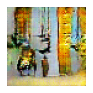

[5934]
0 2837808847_5407af1986.jpg
(1, 64, 64, 3)


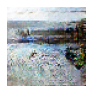

In [43]:
for i in range(2):
  generate_images(gen_model, generate_latent_points(100, 1))

In [39]:
#FID calculation

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from PIL import Image
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
# load the image
image = Image.open('path_to_generated_image')
# convert image to numpy array
images1 = asarray(image)
images1=numpy.resize(images1, (10,32,32,3))
images1 = images1.reshape((10,32,32,3))
image2 = Image.open('path_to_real_image')
# convert image to numpy array
images2 = asarray(image2)
# images2 = randint(0, 255, 10*32*32*3)
images2=numpy.resize(images2, (10,32,32,3))
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

87924736/87910968 [==============================] - 0s 0us/step


FileNotFoundError: ignored